In [1]:
import os
import pandas as pd
import numpy as np
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import geohexgrid as ghg
from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import mapclassify

from scipy.stats import norm

from sklearn.neighbors import KernelDensity

## load underlying shapefile and generate grid

In [2]:
os.listdir('../data-week-01/')

['master-plan-2019-planningarea.cpg',
 'hdb_data_2023.csv.xz',
 'master-plan-2019-planningarea.prj',
 'master-plan-2019-planningarea.shp',
 'master-plan-2019-planningarea.shx',
 'hdb_data_2013.csv.xz',
 'master-plan-2019-planningarea.qmd',
 'master-plan-2019-planningarea.dbf']

<Axes: >

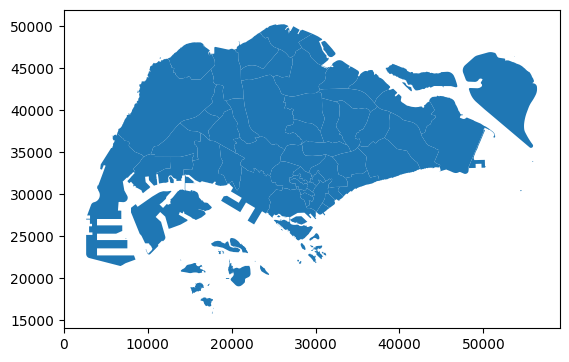

In [3]:
f = 'master-plan-2019-planningarea.shp'
pln = gpd.read_file('../data-week-01/master-plan-2019-planningarea.shp')
pln = pln.to_crs('epsg:3414')
pln.plot()

In [7]:
pln[['PLN_AREA_C', 'PLN_AREA_N', 'geometry']].head()

PLN_AREA_C               PLN_AREA_N  \
0         WC  WESTERN WATER CATCHMENT   
1         CL                 CLEMENTI   
2         RC                   ROCHOR   
3         PG                  PUNGGOL   
4         CC  CENTRAL WATER CATCHMENT   

                                            geometry  
0  MULTIPOLYGON Z (((12927.538 37463.172 0.000, 1...  
1  POLYGON Z ((20732.662 30538.928 0.000, 20714.8...  
2  POLYGON Z ((30306.001 31670.652 0.000, 30312.5...  
3  POLYGON Z ((37558.956 41724.067 0.000, 37535.6...  
4  POLYGON Z ((25073.293 43675.363 0.000, 25130.7...

geometry  index_right     Name  \
13  POLYGON ((2667.538 22248.721, 3167.538 22248.7...           31  kml_112   
14  POLYGON ((2667.538 22748.721, 3167.538 22748.7...           31  kml_112   
15  POLYGON ((2667.538 23248.721, 3167.538 23248.7...           31  kml_112   
16  POLYGON ((2667.538 23748.721, 3167.538 23748.7...           31  kml_112   
17  POLYGON ((2667.538 24248.721, 3167.538 24248.7...           31  kml_112   

   SUBZONE_NO   SUBZONE_N SUBZONE_C PLN_AREA_N PLN_AREA_C     REGION_N  \
13          3  TUAS NORTH    TSSZ03       TUAS         TS  WEST REGION   
14          3  TUAS NORTH    TSSZ03       TUAS         TS  WEST REGION   
15          3  TUAS NORTH    TSSZ03       TUAS         TS  WEST REGION   
16          3  TUAS NORTH    TSSZ03       TUAS         TS  WEST REGION   
17          3  TUAS NORTH    TSSZ03       TUAS         TS  WEST REGION   

   REGION_C PA_Rakuten         X          Y  
13       WR       TUAS  2917.538  22498.721  
14       WR       TUAS  2917.538  22998.721  
15       WR       TUAS  2917.538  23498.721  
16       WR       TUAS  2917.538  23998.721  
17       WR       TUAS  2917.538  24498.721

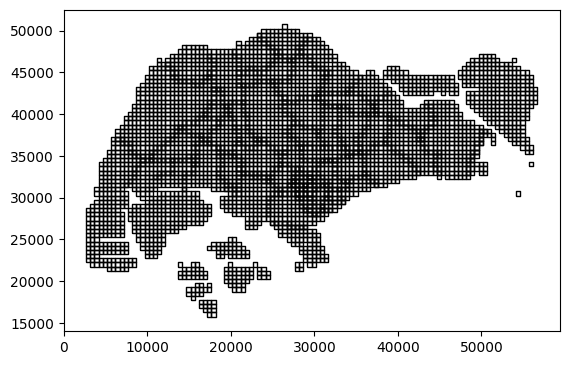

In [4]:
xmin, ymin, xmax, ymax = pln.total_bounds

length = 500
wide = 500

cols = list(np.arange(xmin, xmax + wide, wide))
rows = list(np.arange(ymin, ymax + length, length))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))
sq_grid = gpd.GeoDataFrame({'geometry':polygons}, crs='epsg:3414')
sq_grid = sq_grid.sjoin(pln)
sq_grid['X'] = [p.xy[0][0] for p in sq_grid.geometry.centroid]
sq_grid['Y'] = [p.xy[1][0] for p in sq_grid.geometry.centroid]
sq_grid.plot(fc='none', ec='k')
sq_grid.head()

In [5]:
#sq_xy = [(p.xy[0][0], p.xy[1][0]) for p in sq_grid.geometry.centroid]
#sq_grid['X'] = [p.xy[0][0] for p in sq_grid.geometry.centroid]
#sq_grid['X'] = [p.xy[1][0] for p in sq_grid.geometry.centroid]

## load point data (2013 and 2023) and plot

In [6]:
df_2013 = pd.read_csv('../data-week-01/hdb_data_2013.csv.xz')
df_2023 = pd.read_csv('../data-week-01/hdb_data_2023.csv.xz')

In [10]:
df_2013.groupby('flat_type')['month'].count()

flat_type
1 ROOM                 6
2 ROOM               208
3 ROOM              4813
4 ROOM              6165
5 ROOM              3576
EXECUTIVE           1322
MULTI-GENERATION       7
Name: month, dtype: int64

In [223]:
## this part is optional, for creating geodataframe from csv
gdf_2013 = gpd.GeoDataFrame(df_2013, 
    geometry=[Point(x,y) for x,y in zip(df_2013['X'], df_2013['Y'])], 
    crs='epsg:3414')
gdf_2023 = gpd.GeoDataFrame(df_2023, 
    geometry=[Point(x,y) for x,y in zip(df_2023['X'], df_2023['Y'])], 
    crs='epsg:3414')

<Axes: >

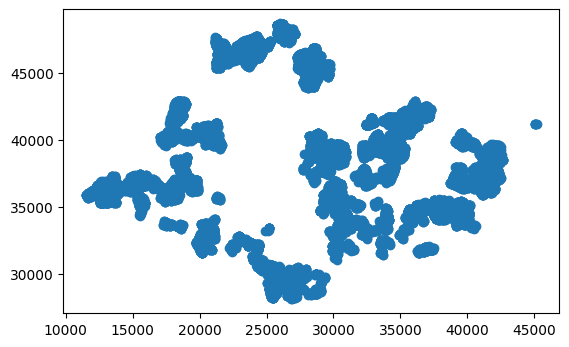

In [31]:
gdf_2013.plot()

<Axes: >

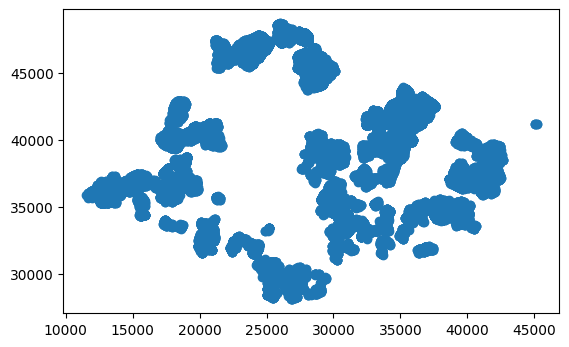

In [32]:
gdf_2023.plot()

## compare density estimated with Gaussian and Epanechnikov kernel functions, and different bandwidth, using square grid

In [35]:
## prepare point location data
Xdata13 = df_2013[['X', 'Y']]
Xdata23 = df_2023[['X', 'Y']]

<Axes: >

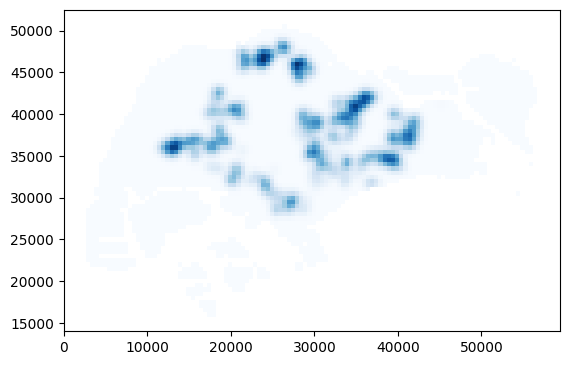

In [129]:
kde13_g1000 = KernelDensity(kernel='gaussian', bandwidth=1000).fit(Xdata13)
kde13_g500 = KernelDensity(kernel='gaussian', bandwidth=500).fit(Xdata13)
kde13_e1000 = KernelDensity(kernel='epanechnikov', bandwidth=1000).fit(Xdata13)
kde13_e500 = KernelDensity(kernel='epanechnikov', bandwidth=500).fit(Xdata13)
sq_grid['kde_13_g1k'] = np.exp(kde13_g1000.score_samples(sq_grid[['X', 'Y']]))
sq_grid['kde_13_g5h'] = np.exp(kde13_g500.score_samples(sq_grid[['X', 'Y']]))
sq_grid['kde_13_e1k'] = np.exp(kde13_e1000.score_samples(sq_grid[['X', 'Y']]))
sq_grid['kde_13_e5h'] = np.exp(kde13_e500.score_samples(sq_grid[['X', 'Y']]))
sq_grid.plot('kde_13_g5h', cmap='Blues')

<Axes: >

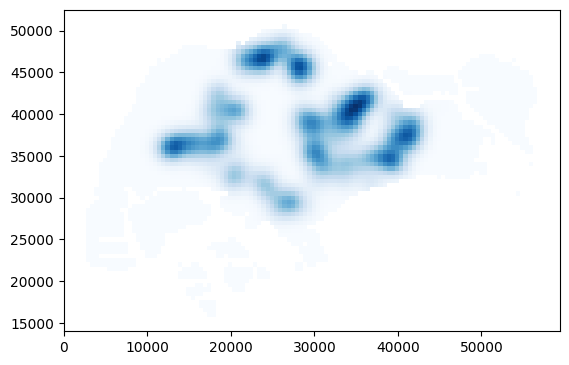

In [130]:
sq_grid.plot('kde_13_g1k', cmap='Blues')

<Axes: >

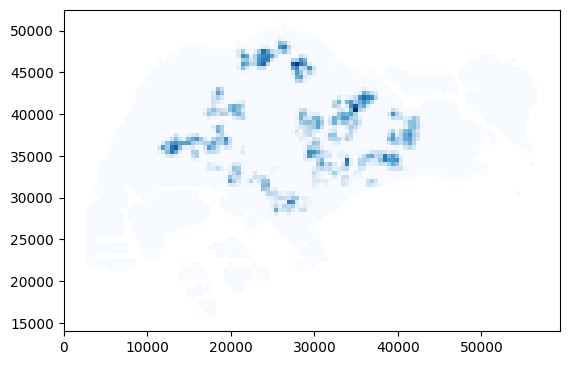

In [131]:
sq_grid.plot('kde_13_e5h', cmap='Blues')

<Axes: >

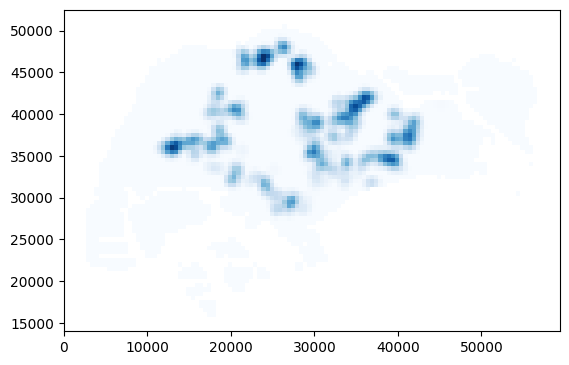

In [132]:
sq_grid.plot('kde_13_e1k', cmap='Blues')

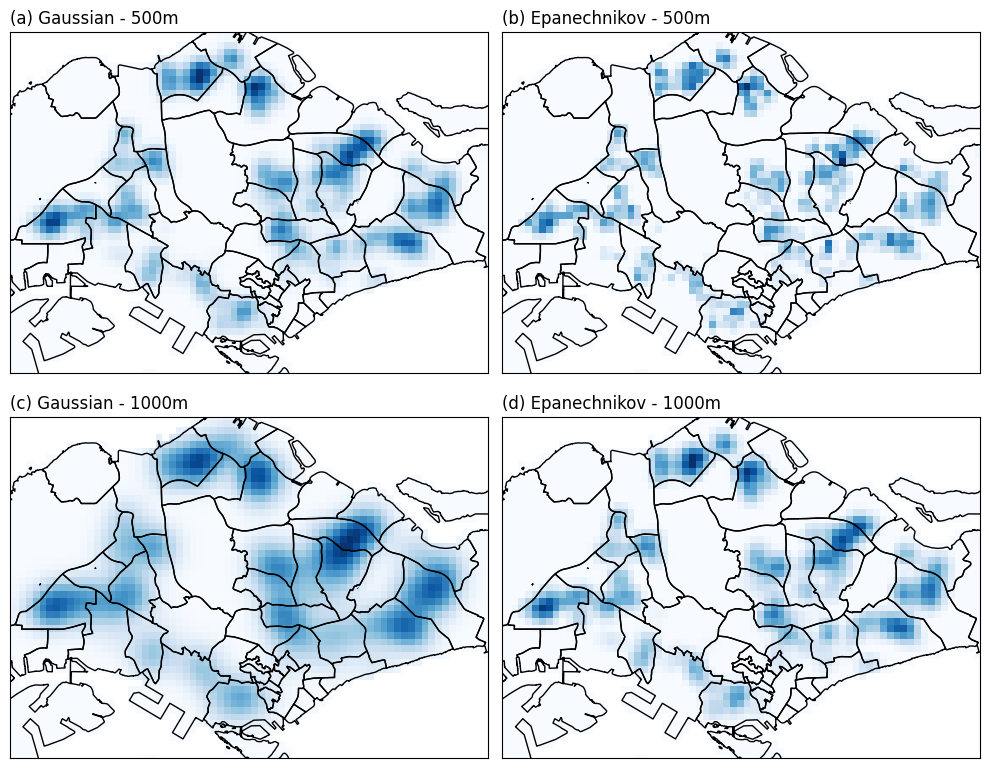

In [133]:
fig, axg = plt.subplots(2, 2, figsize=(10, 8))
axs = axg.flatten()

sq_grid.plot('kde_13_g5h', cmap='Blues', ax=axs[0])
sq_grid.plot('kde_13_e5h', cmap='Blues', ax=axs[1])
sq_grid.plot('kde_13_g1k', cmap='Blues', ax=axs[2])
sq_grid.plot('kde_13_e1k', cmap='Blues', ax=axs[3])

titles = ['Gaussian - 500m',  'Epanechnikov - 500m', 
          'Gaussian - 1000m', 'Epanechnikov - 1000m']
labs = 'abcd'
for i, ax in enumerate(axs):
    pln.plot(ax=ax, fc='none', ec='k')
    ax.set_xlim([10000, 45000])
    ax.set_ylim([25000, 50000])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('({}) {}'.format(labs[i], titles[i]), loc='left')

plt.tight_layout()

## generate hexagon grid

cell_id                                           geometry        X  \
184   47,73  POLYGON ((17500.000 15588.457, 17750.000 15588...  17625.0   
185   48,74  POLYGON ((17875.000 15804.964, 18125.000 15804...  18000.0   
327   46,76  POLYGON ((17125.000 16237.976, 17375.000 16237...  17250.0   
329   48,76  POLYGON ((17875.000 16237.976, 18125.000 16237...  18000.0   
470   45,77  POLYGON ((16750.000 16454.483, 17000.000 16454...  16875.0   

                Y  
184  15804.963619  
185  16021.469970  
327  16454.482672  
329  16454.482672  
470  16670.989023

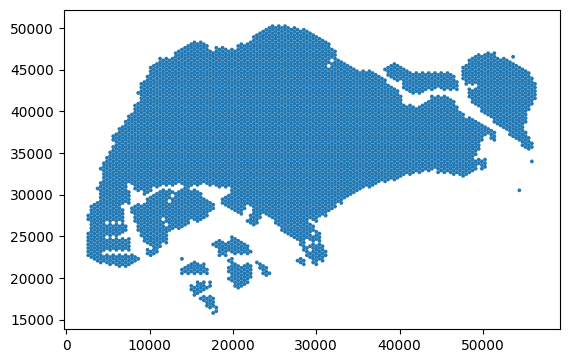

In [11]:
hex_grid = ghg.make_grid_from_gdf(pln, R=250)
hex_grid['X'] = [p.xy[0][0] for p in hex_grid.geometry.centroid]
hex_grid['Y'] = [p.xy[1][0] for p in hex_grid.geometry.centroid]
hex_grid.plot()
hex_grid.head()

## use Gaussian, different bandwidth, on the two years

In [139]:
kde13_g1000 = KernelDensity(kernel='gaussian', bandwidth=1000).fit(Xdata13)
kde13_g500 = KernelDensity(kernel='gaussian', bandwidth=500).fit(Xdata13)
kde23_g1000 = KernelDensity(kernel='gaussian', bandwidth=1000).fit(Xdata23)
kde23_g500 = KernelDensity(kernel='gaussian', bandwidth=500).fit(Xdata23)

hex_grid['kde_13_g1k'] = np.exp(kde13_g1000.score_samples(hex_grid[['X', 'Y']]))
hex_grid['kde_13_g5h'] = np.exp(kde13_g500.score_samples(hex_grid[['X', 'Y']]))
hex_grid['kde_23_g1k'] = np.exp(kde23_g1000.score_samples(hex_grid[['X', 'Y']]))
hex_grid['kde_23_g5h'] = np.exp(kde23_g500.score_samples(hex_grid[['X', 'Y']]))

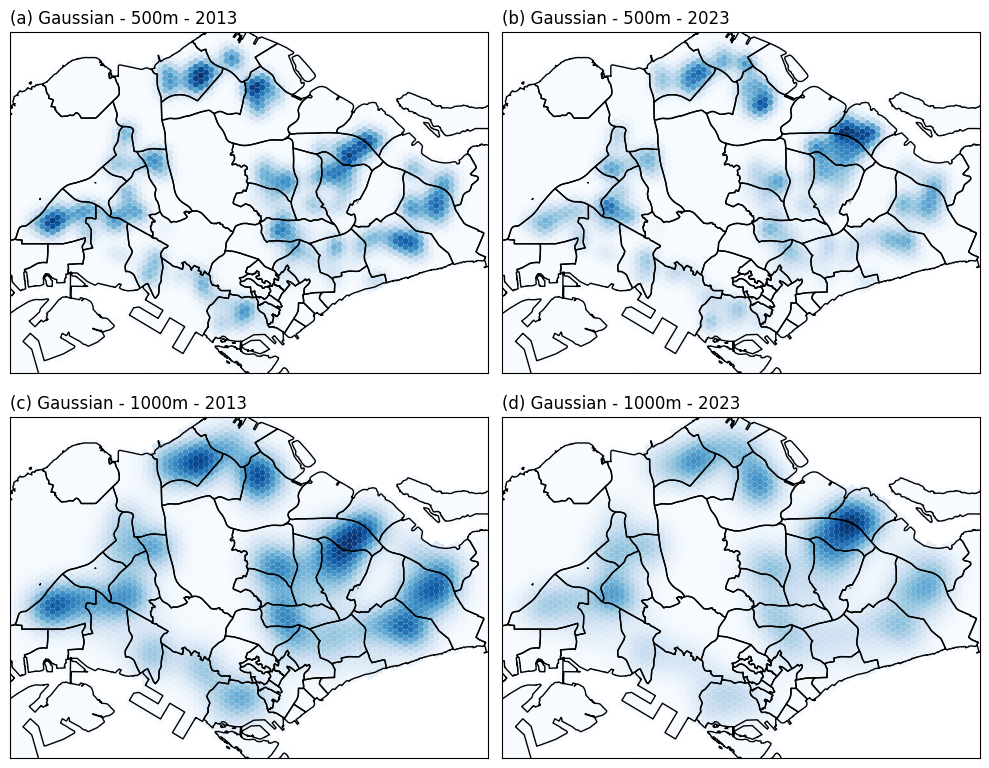

In [140]:
fig, axg = plt.subplots(2, 2, figsize=(10, 8))
axs = axg.flatten()

hex_grid.plot('kde_13_g5h', cmap='Blues', ax=axs[0])
hex_grid.plot('kde_23_g5h', cmap='Blues', ax=axs[1])
hex_grid.plot('kde_13_g1k', cmap='Blues', ax=axs[2])
hex_grid.plot('kde_23_g1k', cmap='Blues', ax=axs[3])

titles = ['Gaussian - 500m - 2013',  'Gaussian - 500m - 2023', 
          'Gaussian - 1000m - 2013', 'Gaussian - 1000m - 2023']
labs = 'abcd'
for i, ax in enumerate(axs):
    pln.plot(ax=ax, fc='none', ec='k')
    ax.set_xlim([10000, 45000])
    ax.set_ylim([25000, 50000])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('({}) {}'.format(labs[i], titles[i]), loc='left')

plt.tight_layout()

the above plot the maps separately (which is fine), but hard to compare between map

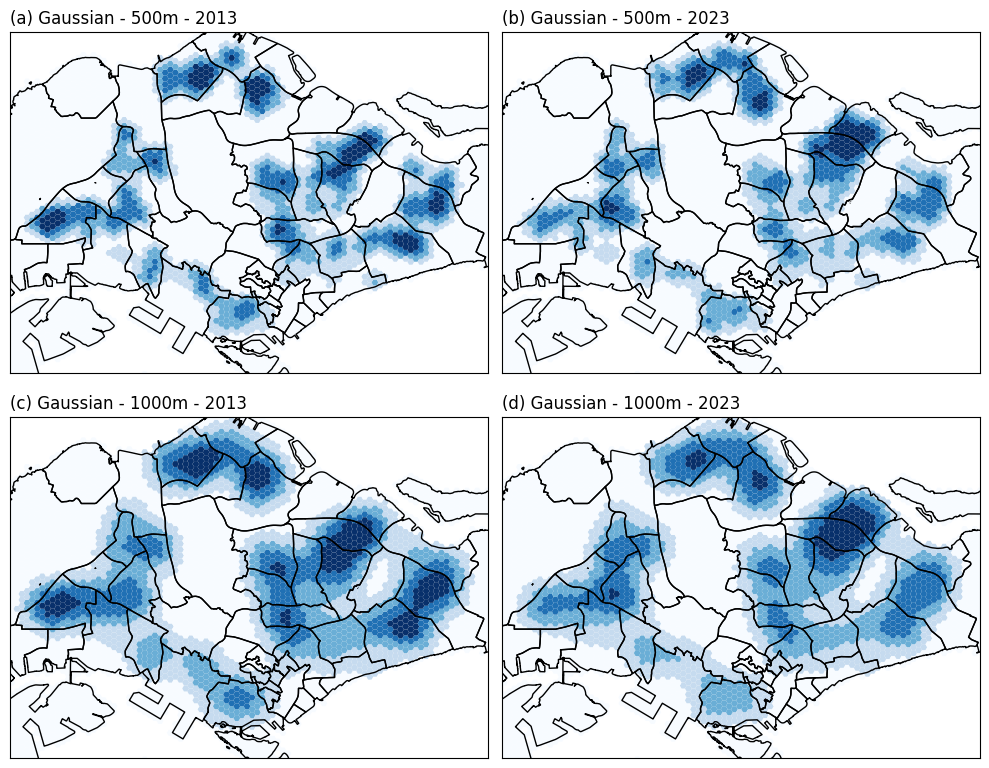

In [181]:
fig, axg = plt.subplots(2, 2, figsize=(10, 8))
axs = axg.flatten()

hex_grid.plot('kde_13_g5h', scheme='NaturalBreaks', cmap='Blues', ax=axs[0])
hex_grid.plot('kde_23_g5h', scheme='NaturalBreaks', cmap='Blues', ax=axs[1])
hex_grid.plot('kde_13_g1k', scheme='NaturalBreaks', cmap='Blues', ax=axs[2])
hex_grid.plot('kde_23_g1k', scheme='NaturalBreaks', cmap='Blues', ax=axs[3])

titles = ['Gaussian - 500m - 2013',  'Gaussian - 500m - 2023', 
          'Gaussian - 1000m - 2013', 'Gaussian - 1000m - 2023']
labs = 'abcd'
for i, ax in enumerate(axs):
    pln.plot(ax=ax, fc='none', ec='k')
    ax.set_xlim([10000, 45000])
    ax.set_ylim([25000, 50000])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('({}) {}'.format(labs[i], titles[i]), loc='left')

plt.tight_layout()

use a single shared break to differentiate colors

In [224]:
all_cols = ['kde_13_g5h', 'kde_13_g1k', 'kde_23_g5h', 'kde_23_g1k']
vs_all = []
for col in all_cols:
    v = hex_grid[col].tolist()
    vs_all.extend(v)
len(vs_all)
breaks = mapclassify.NaturalBreaks(vs_all, k=6)
print(breaks.bins)
#breaks
for col in all_cols:
    v = hex_grid[col].tolist()
    cut = mapclassify.UserDefined(v, bins=breaks.bins)
    yb = cut.yb
    #print(yb)
    hex_grid[col+'_cl'] = yb


[6.94198457e-10 2.07599444e-09 3.70193929e-09 5.80382146e-09
 9.01588960e-09 1.65270412e-08]


In [174]:
cmap = sns.color_palette('Blues', 6)
cmap2 = {i:[c] for i,c in enumerate(cmap)}
cmap

[(0.8584083044982699, 0.9134486735870818, 0.9645674740484429),
 (0.7309496347558632, 0.8394771241830065, 0.9213225682429834),
 (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 (0.32628988850442137, 0.6186236063052672, 0.802798923490965),
 (0.16696655132641292, 0.48069204152249134, 0.7291503267973857),
 (0.044059976931949255, 0.3338869665513264, 0.6244521337946944)]

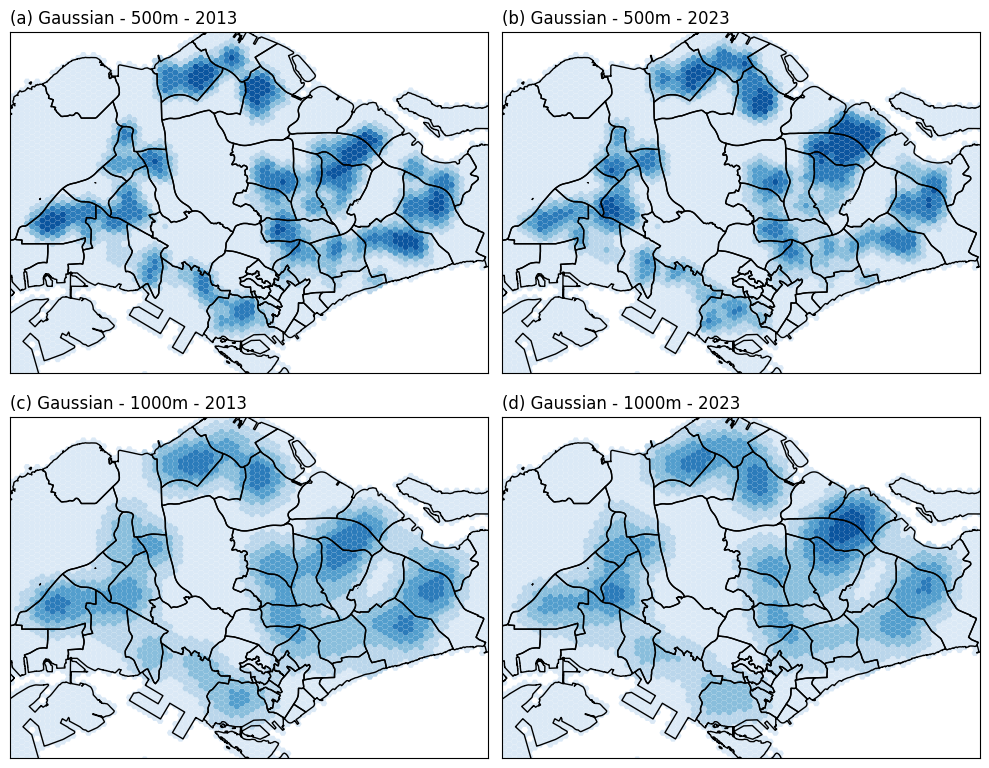

In [179]:
fig, axg = plt.subplots(2, 2, figsize=(10, 8))
axs = axg.flatten()

hex_grid.plot(fc=[cmap2[k] for k in hex_grid['kde_13_g5h_cl']], ax=axs[0])
hex_grid.plot(fc=[cmap2[k] for k in hex_grid['kde_23_g5h_cl']], ax=axs[1])
hex_grid.plot(fc=[cmap2[k] for k in hex_grid['kde_13_g1k_cl']], ax=axs[2])
hex_grid.plot(fc=[cmap2[k] for k in hex_grid['kde_23_g1k_cl']], ax=axs[3])

titles = ['Gaussian - 500m - 2013',  'Gaussian - 500m - 2023', 
          'Gaussian - 1000m - 2013', 'Gaussian - 1000m - 2023']
labs = 'abcd'
for i, ax in enumerate(axs):
    pln.plot(ax=ax, fc='none', ec='k')
    ax.set_xlim([10000, 45000])
    ax.set_ylim([25000, 50000])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('({}) {}'.format(labs[i], titles[i]), loc='left')

plt.tight_layout()

## Dual Kernel Density Estimation

<Axes: >

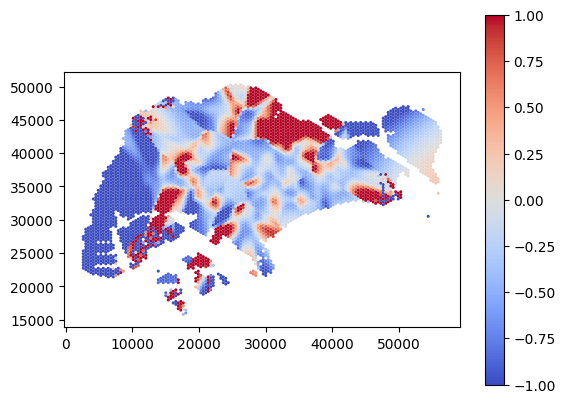

In [222]:
# dual kernel density estimation, log odds difference (magnitude of difference)
hex_grid['compared_5h'] = np.log2(hex_grid['kde_23_g5h'] / hex_grid['kde_13_g5h'])
hex_grid['compared_1k'] = np.log2(hex_grid['kde_23_g1k'] / hex_grid['kde_13_g1k'])

hex_grid.plot('compared_5h', cmap='coolwarm', legend=True, vmin=-1, vmax=1)

<Axes: >

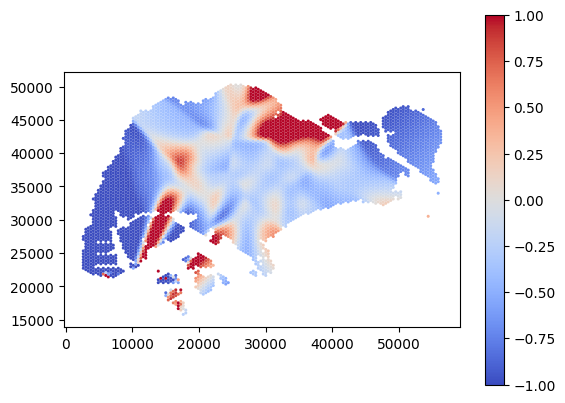

In [191]:
hex_grid.plot('compared_1k', cmap='coolwarm', legend=True, vmin=-1, vmax=1)

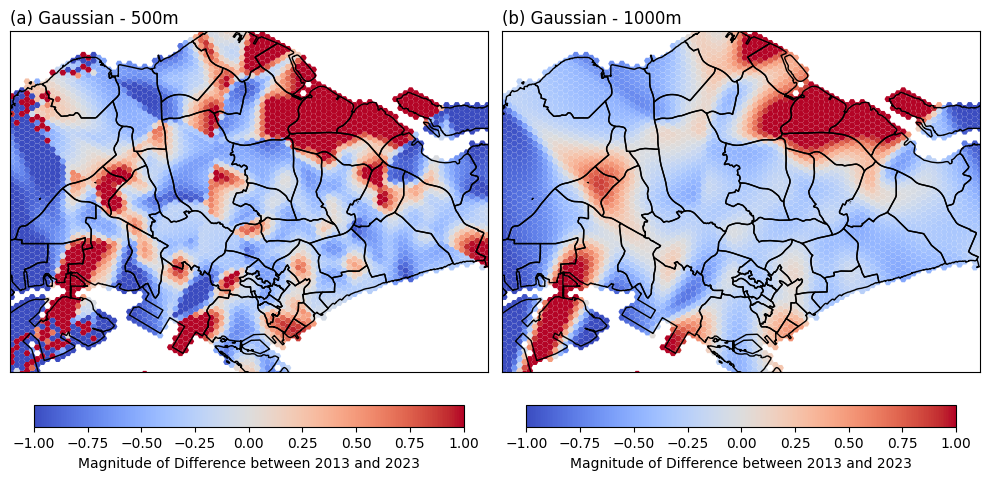

In [220]:
fig, axg = plt.subplots(1, 2, figsize=(10, 5))
axs = axg.flatten()

hex_grid.plot('compared_5h', cmap='coolwarm', legend=True, vmin=-1, vmax=1, ax=axs[0],
    legend_kwds={'label': "Magnitude of Difference between 2013 and 2023", 
        'orientation': "horizontal", "shrink":.9, "pad":0.07})
hex_grid.plot('compared_1k', cmap='coolwarm', legend=True, vmin=-1, vmax=1, ax=axs[1],
    legend_kwds={'label': "Magnitude of Difference between 2013 and 2023", 
        'orientation': "horizontal", "shrink":.9, "pad":0.07})

titles = ['Gaussian - 500m', 'Gaussian - 1000m']
labs = 'ab'
for i, ax in enumerate(axs[:2]):
    pln.plot(ax=ax, fc='none', ec='k')
    ax.set_xlim([10000, 45000])
    ax.set_ylim([25000, 50000])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('({}) {}'.format(labs[i], titles[i]), loc='left')

plt.tight_layout()

The log odds differences
$$\begin{aligned}
\text{Magnitude of Difference} &= \log_2 \frac{D_{2023}}{D_{2013}}\\
\frac{D_{2023}}{D_{2013}} &= 2^{\text{Magnitude of Difference}}
\end{aligned}$$

$$\begin{aligned}
MoD &= 1\\
\frac{D_{2023}}{D_{2013}} &= 2^1 \\
D_{2023} &= 2 \times D_{2013}
\end{aligned}$$

$$\begin{aligned}
MoD &= 0\\
\frac{D_{2023}}{D_{2013}} &= 2^{0} = 1\\
D_{2023} &= D_{2013}
\end{aligned}$$

$$\begin{aligned}
MoD &= -1\\
\frac{D_{2023}}{D_{2013}} &= 2^{-1}\\
D_{2023} &= 0.5 \times D_{2013}
\end{aligned}$$

Other approach: 
- absolute difference of density

In [17]:
Xdata23a = df_2023[df_2023['flat_type']=='4 ROOM']
Xdata23b = df_2023[df_2023['flat_type']=='5 ROOM']
Xdata23c = df_2023[df_2023['flat_type']=='3 ROOM']
len(Xdata23a), len(Xdata23b), len(Xdata23c)

Xdata23a = Xdata23a[['X', 'Y']]
Xdata23b = Xdata23b[['X', 'Y']]
Xdata23c = Xdata23c[['X', 'Y']]
Xdata23a

X             Y
62     29258.918484  38653.096732
63     30036.287145  38360.762068
64     30613.602079  38603.535360
65     30263.228496  38499.844906
66     30291.199291  38778.213196
...             ...           ...
25718  27521.198035  45268.547947
25719  28107.303488  45524.098203
25720  28246.274546  44060.806242
25721  28447.340767  43958.916218
25722  28549.903194  44008.041034

[11358 rows x 2 columns]

In [18]:
kde23_a = KernelDensity(kernel='gaussian', bandwidth=750).fit(Xdata23a)
kde23_b = KernelDensity(kernel='gaussian', bandwidth=750).fit(Xdata23b)
kde23_c = KernelDensity(kernel='gaussian', bandwidth=750).fit(Xdata23c)

hex_grid['kde_23a'] = np.exp(kde23_a.score_samples(hex_grid[['X', 'Y']]))
hex_grid['kde_23b'] = np.exp(kde23_b.score_samples(hex_grid[['X', 'Y']]))
hex_grid['kde_23c'] = np.exp(kde23_c.score_samples(hex_grid[['X', 'Y']]))

<Axes: >

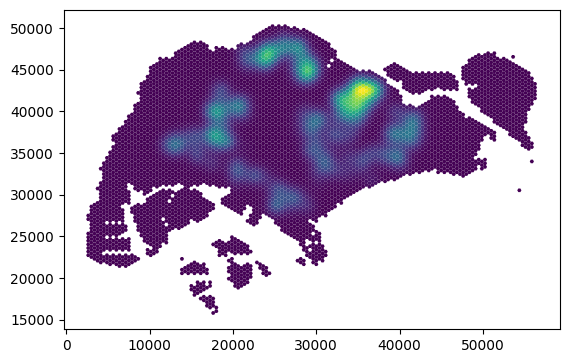

In [20]:
hex_grid.plot('kde_23a')

<Axes: >

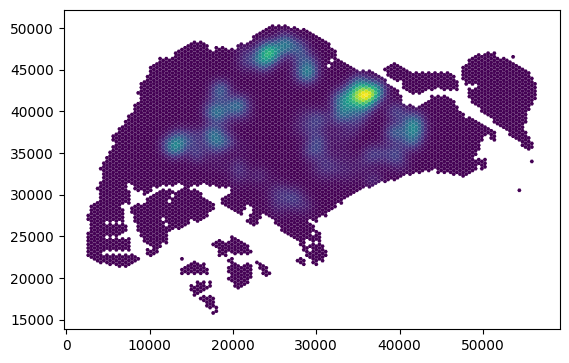

In [21]:
hex_grid.plot('kde_23b')

<Axes: >

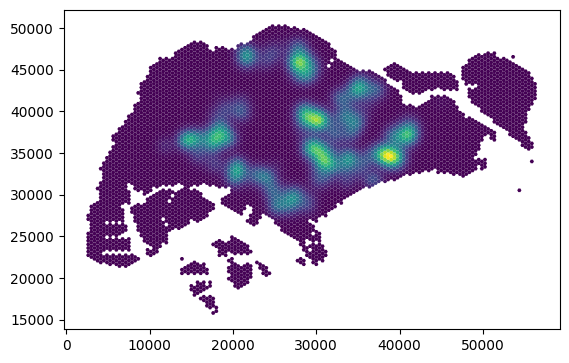

In [22]:
hex_grid.plot('kde_23c')

In [23]:
750*4.5/10

337.5